In [240]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from datetime import datetime
from pprint import pprint
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

In [241]:
### Apply Survival Analysis to loan recurrence on Companies House

In [254]:
usecols = ['CompanyName', 'CompanyNumber', 'Sics', 'CompanyStatus', 'RegAddress.PostCode', 'IncorporationDate',
           'Mortgages.NumMortCharges']

corig = pd.read_csv('ch_companies_clean_1.csv', index_col=None, 
                    usecols=usecols, dtype={'CompanyNumber': str})

print(corig.shape)
corig.head(2)

(4400981, 7)


,CompanyName,CompanyNumber,Sics,RegAddress.PostCode,CompanyStatus,IncorporationDate,Mortgages.NumMortCharges
0,! LTD,08209948,99999 - Dormant Company,LS10 2RU,Active,11/09/2012,0
1,!? LTD,11399177,47710 - Retail sale of clothing in specialised...,SK6 3DY,Active,05/06/2018,0


In [255]:
usecols = ['CompanyNumber', 'delivered_on']

horig = pd.read_csv('ch_charges_clean_1.csv', index_col=None, 
                    usecols=usecols, dtype={'CompanyNumber': str})

print(horig.shape)
horig.head()

(2442388, 2)


,CompanyNumber,delivered_on
0,00609565,1988-02-15T00:00:00.000Z
1,00609565,1988-01-15T00:00:00.000Z
2,00609565,1987-12-11T00:00:00.000Z
3,00609565,1987-11-20T00:00:00.000Z
4,00609565,1987-11-10T00:00:00.000Z


In [305]:
cedit = corig.copy()
hedit = horig.copy()

## Clean and Merge Data

In [396]:
### Sics - chemists 47730 / Dentist 86230 / scaffold 43991 
cedit = cedit[cedit.Sics.str.contains('Dispensing chemist|Dental practice') == True]
cedit = cedit[cedit.CompanyStatus == 'Active']
cedit['Outcode'] = cedit['RegAddress.PostCode'].astype(str).str[:2]
cedit = cedit[(cedit.Outcode.isin(['SE', 'SW', 'NW', 'EC']))]

print(cedit.shape)

(810, 8)


In [397]:
medit = pd.merge(hedit, cedit, how='right', on='CompanyNumber')

print(medit.shape)
medit.head(2)

(1583, 9)


,CompanyNumber,delivered_on,CompanyName,Sics,RegAddress.PostCode,CompanyStatus,IncorporationDate,Mortgages.NumMortCharges,Outcode
0,02164270,2018-12-18T00:00:00.000Z,BMI HEALTHCARE LIMITED,"86101 - Hospital activities, 86220 - Specialis...",EC4M 6XH,Active,15/09/1987,53,EC
1,02164270,2018-12-18T00:00:00.000Z,BMI HEALTHCARE LIMITED,"86101 - Hospital activities, 86220 - Specialis...",EC4M 6XH,Active,15/09/1987,53,EC


In [398]:
### Our Falses; False if the event was lost (right-censored). 
medit.tail(2)

,CompanyNumber,delivered_on,CompanyName,Sics,RegAddress.PostCode,CompanyStatus,IncorporationDate,Mortgages.NumMortCharges,Outcode
1581,11637434,NaN,ZERUSEN LTD,86230 - Dental practice activities,SE3 8LS,Active,23/10/2018,0,SE
1582,08558902,NaN,ZN & SK CO. LTD,86230 - Dental practice activities,NW4 2QR,Active,06/06/2013,0,NW


In [399]:
def dentist_or_chemist(x):
    if 'Dental practice activities' in x:
        return 'Dentist'
    else:
        return 'Chemist'

In [400]:
def event(x):
    if x == 0:
        return 0
    else:
        return 1

In [401]:
medit['Profession'] = medit.Sics.apply(dentist_or_chemist)
medit.delivered_on.fillna(value=datetime.now(), inplace=True)
medit.delivered_on = pd.to_datetime(medit.delivered_on, utc=True)
medit.IncorporationDate = pd.to_datetime(medit.IncorporationDate, utc=True)
medit['Event'] = medit['Mortgages.NumMortCharges'].apply(event)
medit = medit[medit.IncorporationDate > '1990-01-01']
medit['Tenure'] = (medit.delivered_on - medit.IncorporationDate).dt.days
medit = medit[medit.Tenure > 0]

print(medit.shape)
medit.head(5)

(1170, 12)


,CompanyNumber,delivered_on,CompanyName,Sics,RegAddress.PostCode,CompanyStatus,IncorporationDate,Mortgages.NumMortCharges,Outcode,Profession,Event,Tenure
53,03199438,2008-06-19 00:00:00+00:00,INCABELL LIMITED,47730 - Dispensing chemist in specialised stor...,EC1V 7RP,Active,1996-05-16 00:00:00+00:00,19,EC,Chemist,1,4417
54,03199438,2008-06-19 00:00:00+00:00,INCABELL LIMITED,47730 - Dispensing chemist in specialised stor...,EC1V 7RP,Active,1996-05-16 00:00:00+00:00,19,EC,Chemist,1,4417
55,03199438,2008-06-19 00:00:00+00:00,INCABELL LIMITED,47730 - Dispensing chemist in specialised stor...,EC1V 7RP,Active,1996-05-16 00:00:00+00:00,19,EC,Chemist,1,4417
56,03199438,2008-06-19 00:00:00+00:00,INCABELL LIMITED,47730 - Dispensing chemist in specialised stor...,EC1V 7RP,Active,1996-05-16 00:00:00+00:00,19,EC,Chemist,1,4417
57,03199438,2008-06-19 00:00:00+00:00,INCABELL LIMITED,47730 - Dispensing chemist in specialised stor...,EC1V 7RP,Active,1996-05-16 00:00:00+00:00,19,EC,Chemist,1,4417


In [402]:
medit.Event.value_counts()

1    656
0    514
Name: Event, dtype: int64

In [404]:
# Dedup; still need to remove dups within date range
medit = medit.loc[medit.groupby('CompanyNumber')['Tenure'].idxmin()]

print(len(medit))
print(len(medit.CompanyNumber.unique()))

748
748


In [405]:
sedit = medit.copy()
sedit = sedit[['CompanyName', 'CompanyNumber', 'Outcode', 'Profession', 'Tenure', 'Event']]
sedit.head(10)

,CompanyName,CompanyNumber,Outcode,Profession,Tenure,Event
1479,SEJADE LIMITED,02463620,SW,Chemist,10892,0
995,SAAJ LIMITED,02552593,SW,Chemist,3616,1
1042,HEMEEMA LIMITED,02583240,SW,Chemist,847,1
714,ASHZONE LIMITED,02588967,SW,Chemist,550,1
1437,PREMSON LIMITED,02597062,NW,Chemist,10518,0
206,KEYCIRCLE LIMITED,02626265,EC,Chemist,2674,1
766,CHARTCHEM LIMITED,02728581,SW,Chemist,1857,1
855,THE PEMBERDEEN LASER COSMETIC SURGERY CLINIC L...,02780573,SE,Dentist,8390,1
655,FLOWERTOUR LIMITED,02784736,SW,Chemist,405,1
926,RUISLIP CERAMICS LIMITED,02824093,EC,Dentist,1777,1


## Start SA 

In [406]:
kmf = KaplanMeierFitter()

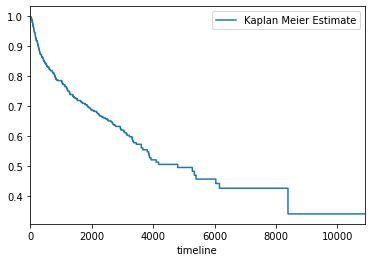

In [407]:
kmf.fit(sedit.Tenure, sedit.Event, label='Kaplan Meier Estimate')
kmf.plot(ci_show=False)

In [408]:
T = sedit.Tenure
E = sedit.Event
groups = sedit.Profession
dentists = (groups == 'Dentist')
chemists = (groups == 'Chemist')

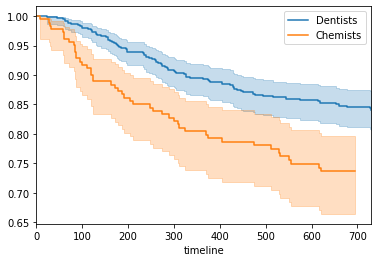

In [409]:
kmf1 = KaplanMeierFitter()

## fit the model for 1st cohort
kmf1.fit(T[dentists], E[dentists], label='Dentists')
a1 = kmf1.plot(loc=slice(0, 730))

## fit the model for 2nd cohort
kmf1.fit(T[chemists], E[chemists], label='Chemists')
kmf1.plot(ax=a1, loc=slice(0, 730))

In [410]:
dedit = sedit.copy()
dedit = dedit[dedit.Profession == 'Dentist']

T2 = dedit.Tenure
E2 = dedit.Event
groups = sedit.Outcode
se = (groups == 'SE')
sw = (groups == 'SW')
nw = (groups == 'NW')

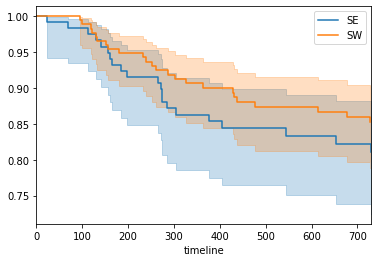

In [416]:
kmf2 = KaplanMeierFitter()

kmf2.fit(T2[se], E2[se], label='SE')
a2 = kmf2.plot(loc=slice(0, 730))


kmf2.fit(T2[sw], E2[sw], label='SW')

kmf2.plot(ax=a2, loc=slice(0, 730))

## 2nd Occurance

In [412]:
# medit = pd.merge(hedit, cedit, how='right', on='CompanyNumber')

# medit['Outcode'] = medit['RegAddress.PostCode'].astype(str).str[:2]
# medit = medit[(medit.Outcode == 'SE') | (medit.Outcode == 'SW') | (medit.Outcode == 'NW')]
# medit['Profession'] = medit.Sics.apply(dentist_or_chemist)
# medit.delivered_on.fillna(value=datetime.now(), inplace=True)
# medit.delivered_on = pd.to_datetime(medit.delivered_on, utc=True)
# medit.IncorporationDate = pd.to_datetime(medit.IncorporationDate, utc=True)
# medit = medit[medit.IncorporationDate > '1990-01-01']
# medit['Tenure'] = (medit.delivered_on - medit.IncorporationDate).dt.days
# medit = medit[medit.Tenure > 0]
# medit['Event'] = medit['Mortgages.NumMortCharges']
# medit = medit[medit.Event > 0]

# print(medit.shape)
# medit.head(2)

In [413]:
# medit = medit[['CompanyNumber', 'Outcode', 'Profession', 'delivered_on']]

# dedup_col = ['CompanyNumber', 'Outcode', 'Profession']

# def dedup_charge(x):

#     return x[dedup_col].duplicated() & x.delivered_on.diff().dt.days.lt(10)

In [414]:
# # medit.delivered_on = pd.to_datetime(medit.delivered_on)
# medit.sort_values(by=dedup_col, inplace=True)
# medit = medit[~medit.groupby(by=dedup_col).apply(dedup_charge).values]

# print(medit.shape)
# medit.head()